#### Importing All Necessory Packages

In [ ]:
import torch
from torch.autograd import grad,Variable
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
import matplotlib as mpl
import time
import scipy as sp

#### Selecting The Device

In [ ]:
dev = torch.device('cpu')
if torch.cuda.is_available():
    print("CUDA is available, running on GPU")
    dev = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print("CUDA not available, running on CPU")

CUDA not available, running on CPU


#### Analytical Solutions

In [ ]:
exactU = lambda X: 1/135 * (68 + 105*X - 40*X**3 + 3*X**5)
exactStrain = lambda x: 1./9. * (x**4 - 8*x**2 + 7)
exactEnergy = lambda eps: (1+eps)**(3/2) - 3/2*eps - 1

#### Defining Parameters

In [ ]:
# ------------------------------ network settings ---------------------------------------------------
iteration = 30
D_in = 1
H = 30
D_out = 1
learning_rate = 1.0

# ----------------------------- define structural parameters ---------------------------------------
Length = 1.0
Height = 1.0
Depth = 1.0
known_left_ux = 0
bc_left_penalty = 1.0

known_right_tx = 0
bc_right_penalty = 1.0
# ------------------------------ define domain and collocation points -------------------------------
Nx = 1000  # 120  # 120
x_min = -1
h = (Length - x_min) / (Nx-1)
# ------------------------------ data testing -------------------------------------------------------
num_test_x = 100

#### Defining The Neural Network

In [ ]:
# ------------------------------ defining the neural network -------------------------------------------------------
model = torch.nn.Sequential(
          torch.nn.Linear(D_in,H),
          torch.nn.Tanh(),
          torch.nn.Linear(H,D_out),)

model = model.to(dev)

In [ ]:
# Alternative way to define the neural network
"""class NeuralNetwork(torch.nn.Module):
    def __init__(self,D_in,H,D_out):
      super(NeuralNetwork,self).__init__()
      self.hidden = torch.nn.Linear(D_in,H)
      self.output = torch.nn.Linear(H,D_out)
      torch.nn.init.constant_(self.hidden.bias,0.0)
      torch.nn.init.constant_(self.output.bias,0.0)
      self.tanh = torch.tanh

    def forward(self,x):
      x = self.hidden(x)
      x = self.tanh(x)
      x = self.output(x)

      return x;

model = NeuralNetwork(D_in,H,D_out)
model = model.to(dev)"""

'class NeuralNetwork(torch.nn.Module):\n    def __init__(self,D_in,H,D_out):\n      super(NeuralNetwork,self).__init__()\n      self.hidden = torch.nn.Linear(D_in,H)\n      self.output = torch.nn.Linear(H,D_out)\n      torch.nn.init.constant_(self.hidden.bias,0.0)\n      torch.nn.init.constant_(self.output.bias,0.0)\n      self.tanh = torch.tanh\n\n    def forward(self,x):\n      x = self.hidden(x)\n      x = self.tanh(x)\n      x = self.output(x)\n\n      return x;\n\nmodel = NeuralNetwork(D_in,H,D_out)\nmodel = model.to(dev)'

#### All of The Dependent functions

In [ ]:
# -------------------------------------------------------------------------------
# Purpose: setting domain and collect database
# -------------------------------------------------------------------------------
def setup_domain():
    x_dom = x_min, Length, Nx
    # create points
    dom = np.array([np.linspace(x_dom[0], x_dom[1], x_dom[2])]).T
    return dom
# -----------------------------------------------------------------------------------------------------
# prepare inputs for testing the model
# -----------------------------------------------------------------------------------------------------
def get_datatest():
    x_dom_test = x_min, Length, num_test_x
    # create points
    x_space = np.sort(np.random.uniform(x_min, Length, size=(num_test_x, 1)), axis=0)
    return x_space
def getEnergyBar1D(u, x):
    dudx = grad(u, x, torch.ones(x.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
    energy = (1 + dudx) ** (3/2) - 3/2*dudx - 1
    return energy

def getU(x):
    u = model(x)
    return (x + 1) * u
# -----------------------------------------------------------------------------------------------------
# Evaluation function for testing the model
# -----------------------------------------------------------------------------------------------------
def evaluate_model(x_space):
    t_tensor = torch.from_numpy(x_space).float()
    t_tensor = t_tensor.to(dev)
    t_tensor.requires_grad_(True)
    u_pred_torch = getU(t_tensor)
    u_pred = u_pred_torch.detach().cpu().numpy()
    dudx_torch = grad(u_pred_torch, t_tensor, torch.ones(t_tensor.shape[0], 1, device=dev))[0]
    dudx = dudx_torch.detach().cpu().numpy()
    return u_pred, dudx

#### Trapezoidal Numerical Integration function

In [ ]:
def __trapz(y, x=None, dx=1.0, axis=-1):
    if x is None:
        d = dx
    else:
        d = x[1:] - x[0:-1]
        # reshape to correct shape
        shape = [1] * y.ndimension()
        shape[axis] = d.shape[0]
        d = d.reshape(shape)
    nd = y.ndimension()
    slice1 = [slice(None)] * nd
    slice2 = [slice(None)] * nd
    slice1[axis] = slice(1, None)
    slice2[axis] = slice(None, -1)
    ret = torch.sum(d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0, axis)
    return ret

def trapz1D( y, x=None, dx=1.0, axis=-1):
    y1D = y.flatten()
    if x is not None:
        x1D = x.flatten()
        return __trapz(y1D, x1D, dx=dx, axis=axis)
    else:
        return __trapz(y1D, dx=dx)

In [ ]:
def my_custon_train(data,iteration,model):
    x = torch.from_numpy(data).float()
    x = x.to(dev)
    x.requires_grad_(True)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate, max_iter=20)
    start_time = time.time()

    energy_loss_array = []
    boundary_loss_array = []
    loss_array = []
    current_Time = time.time()

    for t in range(iteration):
      def closure(): #purpose is to clear the gradient,compute the loss and return it
        u_pred = getU(x)
        u_pred.double()
        potential_energy = getEnergyBar1D(u_pred,x)
        f1 = u_pred*x
        energy_loss = trapz1D(potential_energy,x = x) - trapz1D(f1,x = x)
        boundary_loss = torch.tensor([0])
        loss = energy_loss + boundary_loss
        optimizer.zero_grad()
        loss.backward()
        print('Iter: %d Loss: %.9e Energy: %.9e Boundary: %.9e Time: %.3e'
              % (t + 1, loss.item(), energy_loss.item(), boundary_loss.item(), time.time() - current_Time))
        
        energy_loss_array.append(energy_loss.data)
        boundary_loss_array.append(boundary_loss.data)
        loss_array.append(loss.data)
        return loss
      optimizer.step(closure)
    timeOfTraining = time.time() - start_time
    print('Training Time is : %.4f'% (timeOfTraining))

In [ ]:
dom = setup_domain()
train_start_time = time.time()
my_custon_train(dom,iteration,model)
train_end_time = time.time()

Iter: 1 Loss: 1.658239402e-02 Energy: 1.658239402e-02 Boundary: 0.000000000e+00 Time: 7.873e-02
Iter: 1 Loss: -1.785459220e-01 Energy: -1.785459220e-01 Boundary: 0.000000000e+00 Time: 9.029e-02
Iter: 1 Loss: -1.847070158e-01 Energy: -1.847070158e-01 Boundary: 0.000000000e+00 Time: 9.422e-02
Iter: 1 Loss: -1.850479245e-01 Energy: -1.850479245e-01 Boundary: 0.000000000e+00 Time: 9.826e-02
Iter: 1 Loss: -1.854420304e-01 Energy: -1.854420304e-01 Boundary: 0.000000000e+00 Time: 1.023e-01
Iter: 1 Loss: -1.866030544e-01 Energy: -1.866030544e-01 Boundary: 0.000000000e+00 Time: 1.060e-01
Iter: 1 Loss: -1.884939671e-01 Energy: -1.884939671e-01 Boundary: 0.000000000e+00 Time: 1.098e-01
Iter: 1 Loss: -1.917116344e-01 Energy: -1.917116344e-01 Boundary: 0.000000000e+00 Time: 1.137e-01
Iter: 1 Loss: -1.910033822e-01 Energy: -1.910033822e-01 Boundary: 0.000000000e+00 Time: 1.175e-01
Iter: 1 Loss: -1.935037673e-01 Energy: -1.935037673e-01 Boundary: 0.000000000e+00 Time: 1.212e-01
Iter: 1 Loss: -1.93688

### Prediction of the model

In [ ]:
x_predict = get_datatest()
u_pred_dem, eps_pred_dem = evaluate_model(x_predict)
exact_solution = exactU(x_predict)
exact_eps = exactStrain(x_predict)
error_L2_DEM = np.linalg.norm(exact_solution - u_pred_dem, 2) / np.linalg.norm(exact_solution, 2)
error_H1_DEM = np.linalg.norm(exact_eps - eps_pred_dem, 2) / np.linalg.norm(exact_eps, 2)

In [ ]:
# Plot properties
mpl.rcParams['figure.dpi'] = 100
# fix random seeds
axes = {'labelsize' : 'large'}
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 17}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize' : 7}
mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)
npr.seed(2019)
torch.manual_seed(2019)

## Results

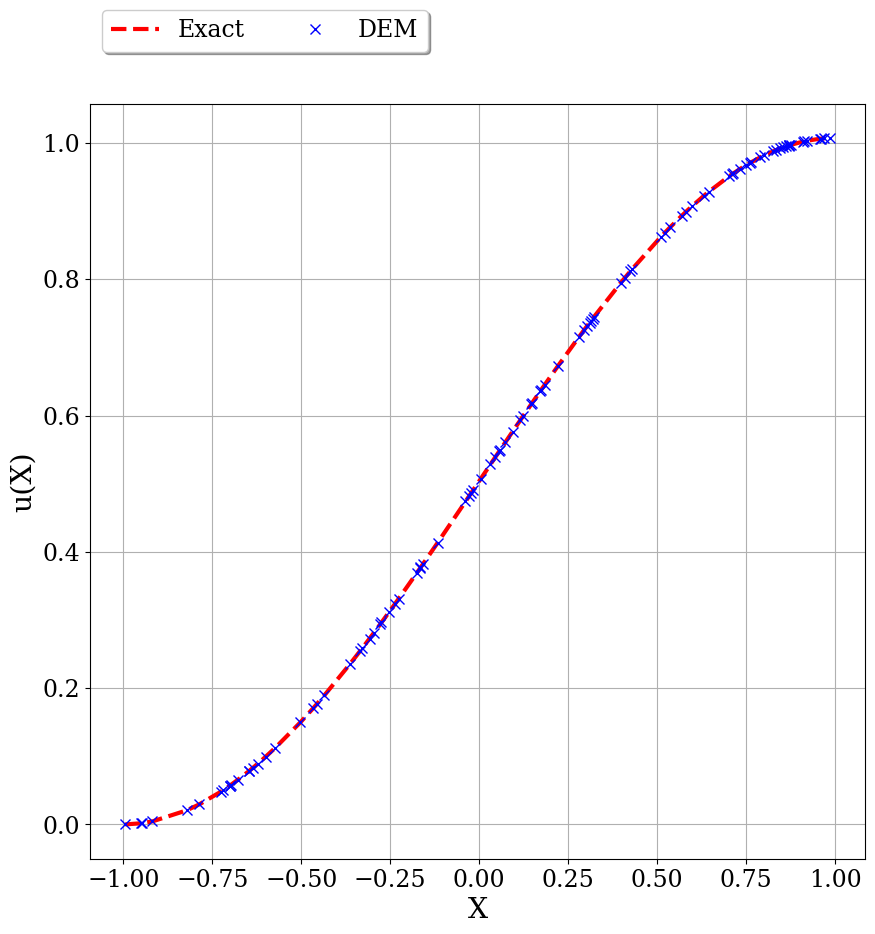

In [ ]:
fig, dis = plt.subplots(figsize=(10, 10))
dis.plot(x_predict, exact_solution, label="Exact", linestyle='dashed', color='red')
dis.plot(x_predict, u_pred_dem, 'bx', label='DEM')
dis.legend(ncol=4, fancybox=True, shadow=True, loc='upper left', bbox_to_anchor=(0.0, 1.14))
dis.grid(True)
dis.set_xlabel('X')
dis.set_ylabel('u(X)')
plt.savefig('displacement_1D_DEM.pdf')
plt.show()

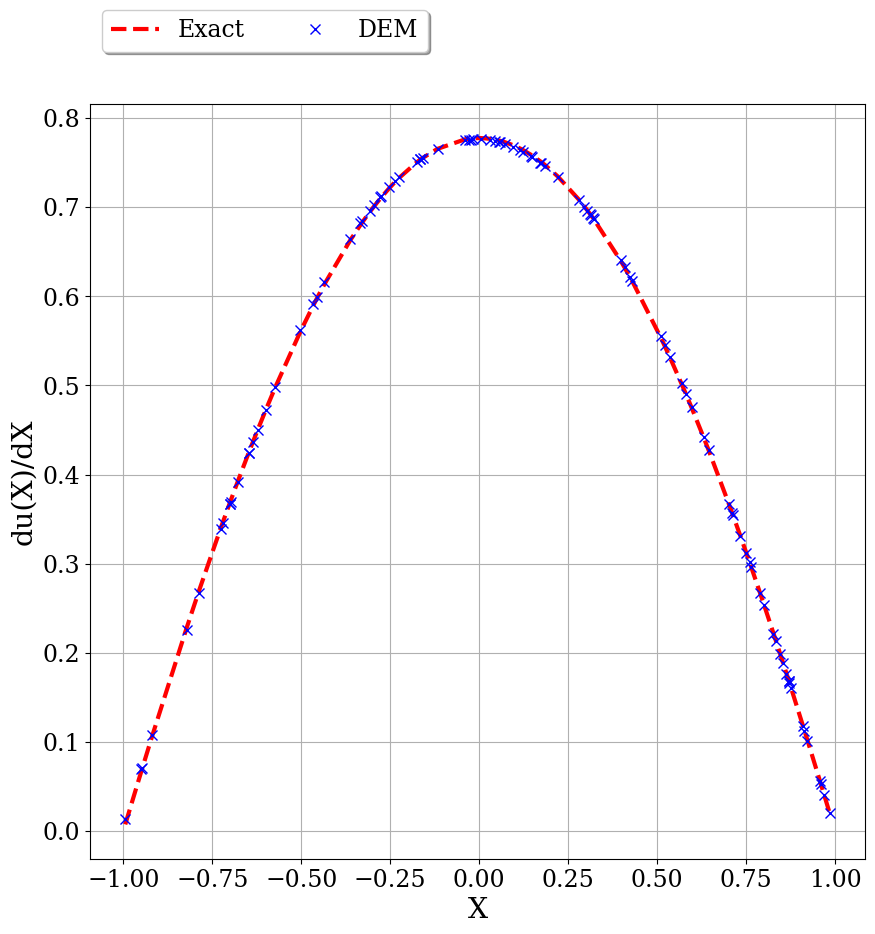

In [ ]:
fig, eps = plt.subplots(figsize=(10,10))
eps.plot(x_predict, exact_eps, label='Exact', linestyle='dashed', color='red')
eps.plot(x_predict, eps_pred_dem, 'bx', label='DEM')
legend = eps.legend(loc='upper right', shadow=True)
eps.legend(ncol=4, fancybox=True, shadow=True, loc='upper left', bbox_to_anchor=(0.0, 1.14))
eps.grid(True)
eps.set_xlabel('X')
eps.set_ylabel('du(X)/dX')
plt.savefig('epsilon_1D_DEM.pdf')
plt.show()

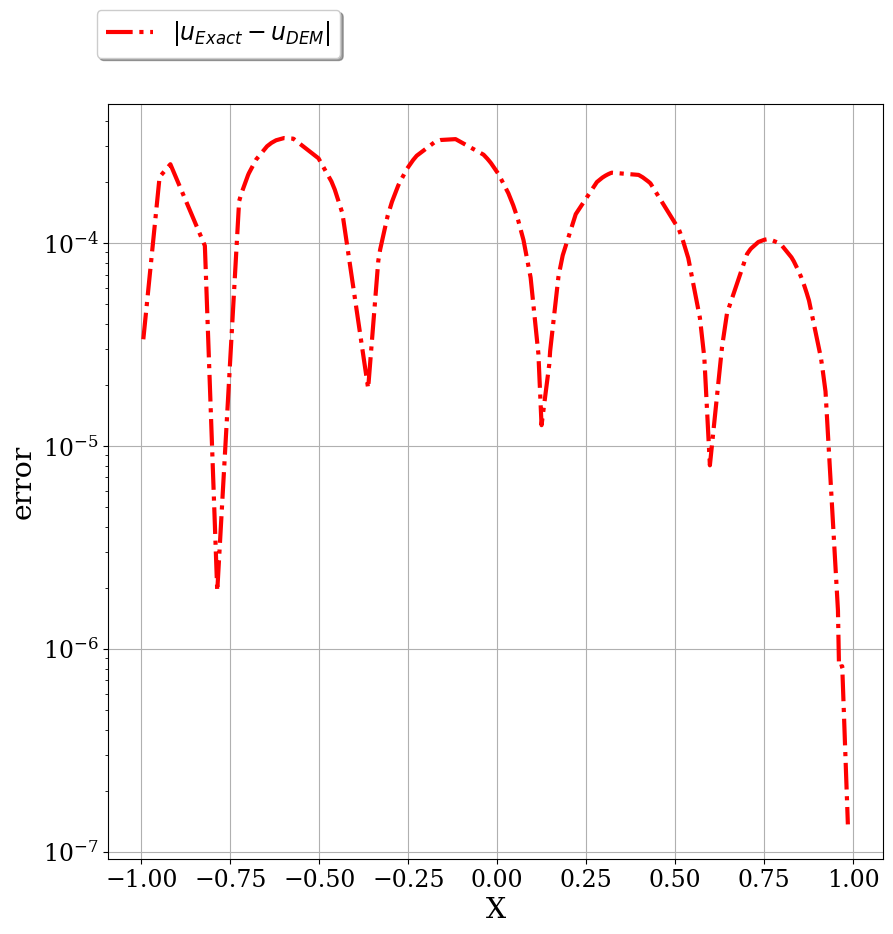

In [ ]:
fig, err_dis = plt.subplots(figsize=(10, 10))

err_dis.semilogy(x_predict, np.abs(exact_solution - u_pred_dem), 'r-.', label=r"$|u_{Exact} - u_{{DEM}}|$")
err_dis.grid(True)
err_dis.set_xlabel('X')
err_dis.set_ylabel('error')
err_dis.legend(ncol=3, fancybox=True, shadow=True, loc='upper left', bbox_to_anchor=(-0.03, 1.14))
plt.savefig('error_dis_1D_DEM.pdf')
plt.show()

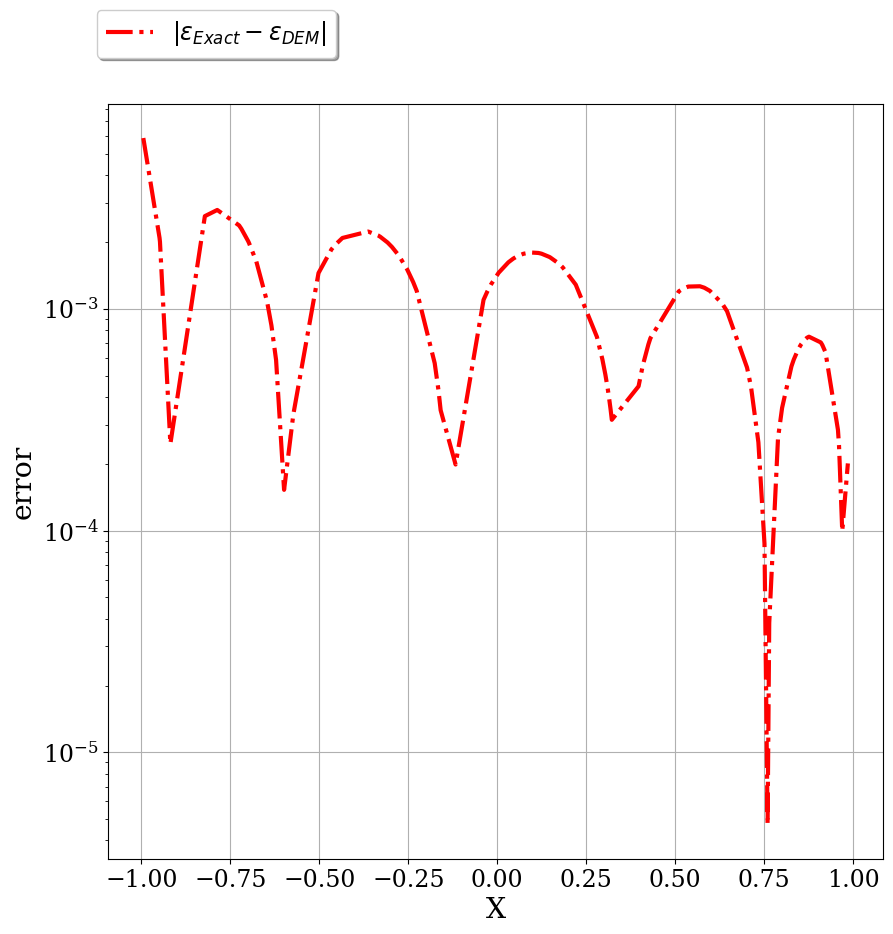

DEM ||e||L2 : 2.64e-04
DEM ||e||H1 : 2.57e-03
DEM time : 0.39


In [ ]:
fig, err_eps = plt.subplots(figsize=(10,10))

err_eps.semilogy(x_predict, np.abs(exact_eps - eps_pred_dem), 'r-.', label='$|\epsilon_{Exact} - \epsilon_{DEM}|$')
err_eps.grid(True)
err_eps.set_xlabel('X')
err_eps.set_ylabel('error')
err_eps.legend(ncol=3, fancybox=True, shadow=True, loc='upper left', bbox_to_anchor=(-0.03, 1.14))
plt.savefig('error_epsilon_1D_DEM.pdf')
plt.show()
print("DEM ||e||L2 : %.2e" % error_L2_DEM)
print("DEM ||e||H1 : %.2e" % error_H1_DEM)
print("DEM time : %.2f" % (train_end_time - train_start_time))